In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
from nltools.data import Brain_Data, Design_Matrix, Adjacency
import networkx as nx
from scipy import signal
from mne_connectivity import spectral_connectivity_epochs
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

from functions.EpiIndex import *
from functions.Connectivity import *

In [2]:
raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/outputs/SR_subseg_filtered.fif', preload=True)
#Reading a npy file 
data = np.load('/home/pablo/works/dev_thesis_SEEG/data/outputs/SR_subseg_connectivity_data_high_freq_pli_dense.npy')
con_data=np.mean(data,axis=3)
ch_names = raw.info['ch_names']

Opening raw data file /home/pablo/works/dev_thesis_SEEG/data/outputs/SR_subseg_filtered.fif...


Isotrak not found
    Range : 4608000 ... 5120000 =   9000.000 ... 10000.000 secs
Ready.
Reading 0 ... 512000  =      0.000 ...  1000.000 secs...


/tmp/ipykernel_1197/1318070016.py:1: RuntimeWarning: This filename (/home/pablo/works/dev_thesis_SEEG/data/outputs/SR_subseg_filtered.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw=mne.io.read_raw_fif('/home/pablo/works/dev_thesis_SEEG/data/outputs/SR_subseg_filtered.fif', preload=True)


In [3]:
# Function to create a frame for the image
def create_frame(matrix, band_name, ch_names, frame_number):
    plt.figure(figsize=(10, 10))
    sns.heatmap(matrix, xticklabels=ch_names, yticklabels=ch_names, cmap='viridis')
    plt.xticks(fontsize=8, rotation=90)
    plt.yticks(fontsize=8)
    plt.title(f'{band_name} - (Epoch) {frame_number}')
    
    # Save the plot to a Pillow image using an in-memory buffer
    buf = io.BytesIO()
    plt.tight_layout()
    plt.savefig(buf, format='png')
    plt.close()
    buf.seek(0)
    return Image.open(buf)

# Create the animation
def create_animation(array, bands, ch_names):
    for i, band_name in enumerate(bands):
        frames = []
        print(f"Creating animation for band: {band_name}")
        for j in range(array.shape[0]):
            matrix = array[j, :, :]
            print(j)
            frame_img = create_frame(matrix, band_name, ch_names, j)
            frames.append(frame_img)

        # Save the frames as an animated GIF
        frames[0].save(f'{band_name}_animation.gif', save_all=True, append_images=frames[1:], duration=500, loop=0)


In [ ]:
bands=['theta + alpha']
#Image plot every connectivity matrix with the names of the channels in a little font
# N_mat=Connectivity_matrixes.shape[0]
# for i in range(N_mat):
#     plt.figure(figsize=(10,10))
#     sns.heatmap(Connectivity_matrixes[i,:,:,0],xticklabels=channels,yticklabels=channels)
#     plt.xticks(fontsize=8, rotation=90)
#     plt.yticks(fontsize=8)
#     plt.title(f'Connectivity matrix at time {i}')
#     plt.show()
create_animation(con_data, bands, ch_names)

In [3]:
# Make sure the matrix is symmetric
#If not, make it symmetric using the lower triangle
Connectivity_matrixes = con_data
N_mat=Connectivity_matrixes.shape[0]
for i in range(N_mat):
    if not np.allclose(Connectivity_matrixes[i,:,:], Connectivity_matrixes[i,:,:].T, atol=1e-8):
        Connectivity_matrixes[i,:,:] = np.tril(Connectivity_matrixes[i,:,:]) + np.tril(Connectivity_matrixes[i,:,:], -1).T
        print(f"Matrix {i} is not symmetric")
    else:
        print(f"Matrix {i} is symmetric")

Matrix 0 is not symmetric
Matrix 1 is not symmetric
Matrix 2 is not symmetric
Matrix 3 is not symmetric
Matrix 4 is not symmetric
Matrix 5 is not symmetric
Matrix 6 is not symmetric
Matrix 7 is not symmetric
Matrix 8 is not symmetric
Matrix 9 is not symmetric
Matrix 10 is not symmetric
Matrix 11 is not symmetric
Matrix 12 is not symmetric
Matrix 13 is not symmetric
Matrix 14 is not symmetric
Matrix 15 is not symmetric
Matrix 16 is not symmetric
Matrix 17 is not symmetric
Matrix 18 is not symmetric
Matrix 19 is not symmetric
Matrix 20 is not symmetric
Matrix 21 is not symmetric
Matrix 22 is not symmetric
Matrix 23 is not symmetric
Matrix 24 is not symmetric
Matrix 25 is not symmetric
Matrix 26 is not symmetric
Matrix 27 is not symmetric
Matrix 28 is not symmetric
Matrix 29 is not symmetric
Matrix 30 is not symmetric
Matrix 31 is not symmetric
Matrix 32 is not symmetric
Matrix 33 is not symmetric
Matrix 34 is not symmetric
Matrix 35 is not symmetric
Matrix 36 is not symmetric
Matrix 37 i

In [4]:
Connectivity_matrixes.shape

(50, 127, 127)

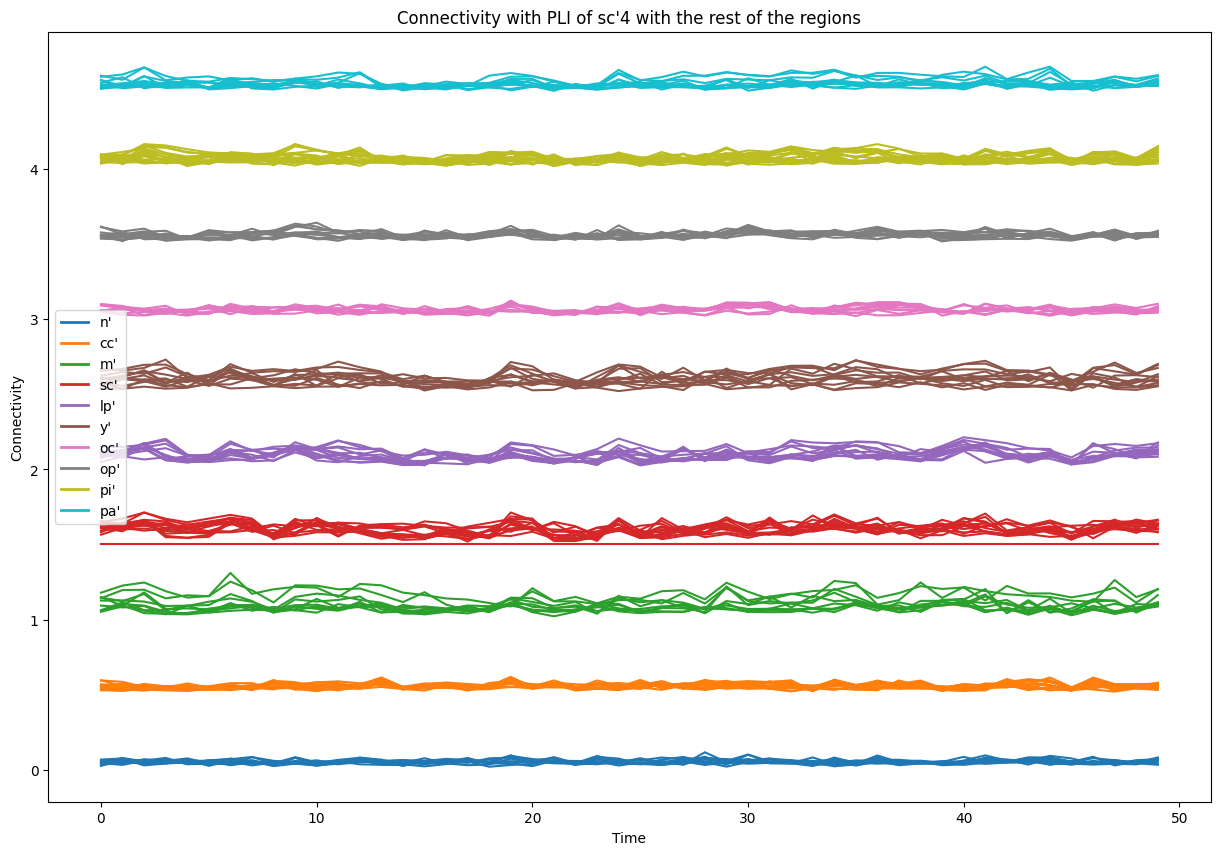

In [5]:
#Now, using the index of every channel, we are going ton generate the corresponding plots for every region
# Get the matrixes which consider the interested channel, e.g. the channel sc'1, 
# and the rest of the channels
#First, get all the rows, for the 150 matrixes
channel_name="sc'4"
method="PLI"
# channel_name="CC01"
channel_index=ch_names.index(channel_name)
#Get the rows
rows=Connectivity_matrixes[:,channel_index,:]
regions=["n'","cc'","m'","sc'","lp'","y'","oc'","op'","pi'","pa'"]
# regions=[ 'OF', 'CR', 'CA', 'CC', 'SC', 'OP', 'IP', 'PM', 'SA', 'CP', 'PA', 'I', 'B', 'C']
#Get the index of every region checking if the regions is in the name of the channel
regions_index=[]
for region in regions:
    for i in range(len(ch_names)):
        if region in ch_names[i]:
            regions_index.append(i)
            break

#Generate labels for the regions
labels=[]
for i in ch_names:
    for region in regions:
        if region in i:
            labels.append(region)
            break 

from itertools import cycle
from matplotlib.lines import Line2D
color_cycle = cycle(plt.cm.tab10.colors)  # Cycle through a colormap
colors = {label: next(color_cycle) for label in regions}

# Plot each group of channels
plt.figure(figsize=(15, 10))

# Offset step to separate different label groups on the y-axis
offset_step = 0.5
current_offset = 0

for label in regions:
    indices = [i for i, l in enumerate(labels) if l == label]
    for i in indices:
        plt.plot(rows[:, i] + current_offset, label=f'{labels[i]} (Channel {i})', color=colors[label])
    current_offset += offset_step

# Create custom legend handles
legend_handles = [Line2D([0], [0], color=colors[label], lw=2, label=label) for label in regions]

# Add the custom legend to the plot
plt.legend(handles=legend_handles)
plt.title(f'Connectivity with {method} of {channel_name} with the rest of the regions')
plt.xlabel('Time')
plt.ylabel('Connectivity')
plt.show()